In [29]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import matplotlib.pyplot as plt

In [30]:
# load the dataset
data = pd.read_csv("Final_DF.csv")

In [31]:
data.head()

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,BTC_Price,ETH_Price,SOL_Price,XRP_Price
0,2020-04-10,99.519997,1662.50,0.05,0.729,41.67,6865.493164,158.412445,0.951054,0.187464
1,2020-04-11,99.519997,1662.50,0.05,0.729,41.67,6859.083008,158.216019,0.776819,0.188063
2,2020-04-12,99.519997,1662.50,0.05,0.729,41.67,6971.091797,161.142426,0.882507,0.190135
3,2020-04-13,99.349998,1662.50,0.05,0.770,41.17,6845.037598,156.279556,0.777832,0.187732
4,2020-04-14,98.889999,1715.85,0.05,0.750,37.76,6842.427734,157.596390,0.661925,0.185335


In [32]:
# combine all cryptocurrencies into one column
data = data.melt(
    id_vars=['Date', 'Dollar_Index', 'Gold_Price', 'Interest_Rate', 'US_10_Year', 'VIX_Value'],
    value_vars=['BTC_Price', 'ETH_Price', 'SOL_Price', 'XRP_Price'],
    var_name='currency_type',
    value_name='price_target'
)

# Map group_id to a standard format (optional)
data['currency_type'] = data['currency_type'].str.replace('_Price', '')

# Sort by date and group_id
data = data.sort_values(by=['Date', 'currency_type']).reset_index(drop=True)

# Display the transformed data
print(data.head())

         Date  Dollar_Index  Gold_Price  Interest_Rate  US_10_Year  VIX_Value  \
0  2020-04-10     99.519997      1662.5           0.05       0.729      41.67   
1  2020-04-10     99.519997      1662.5           0.05       0.729      41.67   
2  2020-04-10     99.519997      1662.5           0.05       0.729      41.67   
3  2020-04-10     99.519997      1662.5           0.05       0.729      41.67   
4  2020-04-11     99.519997      1662.5           0.05       0.729      41.67   

  currency_type  price_target  
0           BTC   6865.493164  
1           ETH    158.412445  
2           SOL      0.951054  
3           XRP      0.187464  
4           BTC   6859.083008  


In [33]:
# convert columns datatypes into appropriate data types
data['Date'] = pd.to_datetime(data['Date'])
data['currency_type'] = data['currency_type'].astype(str).astype("category")

<Axes: title={'center': 'price_target'}, xlabel='[currency_type]'>

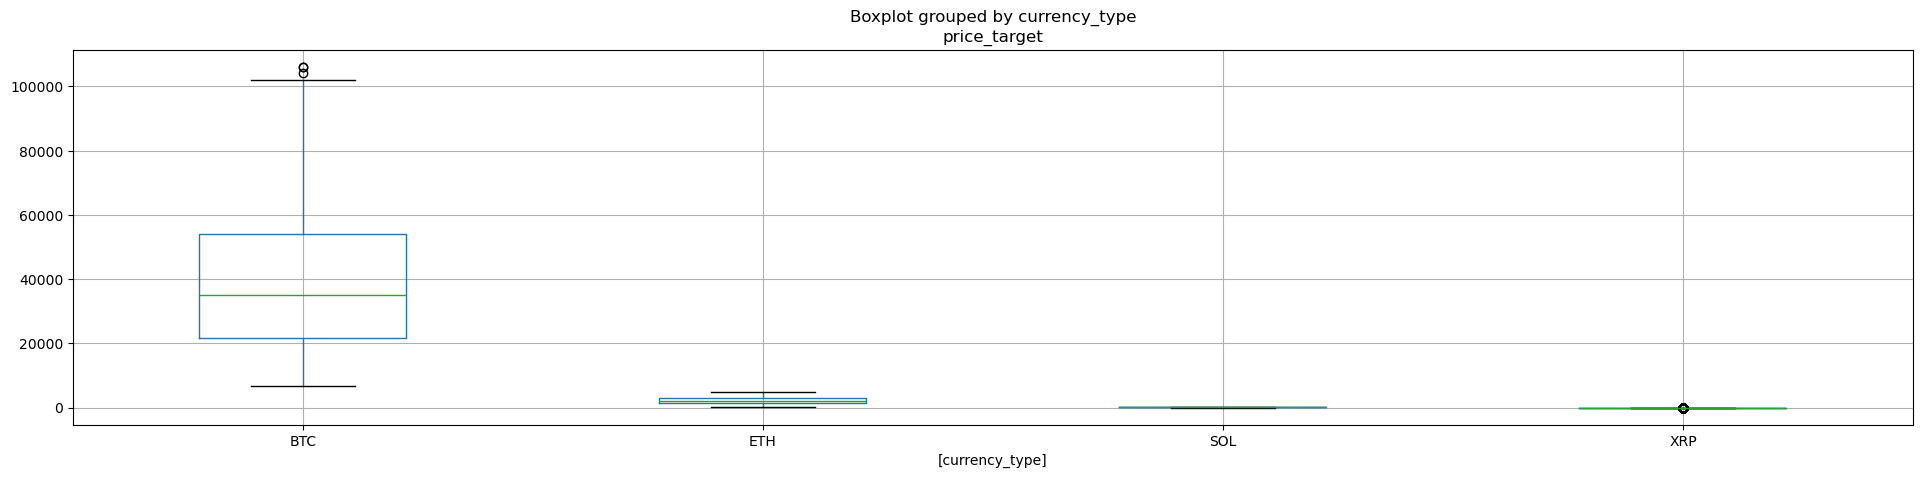

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (23, 5))
data.set_index("Date")[["currency_type", "price_target"]].boxplot(by="currency_type", ax=ax)

In [36]:
from typing import List, Union
import numpy as np
import pandas as pd

CALENDAR_CYCLES = {
    "dayofweek": 7,
    "weekofyear": 52,
    "month": 12,
}

def add_cyclical_calendar_features(df: pd.DataFrame, features: Union[str, List[str]]):
    """Cyclical encoding of calendar features
    NOTE datetime column must be set as index """

    if isinstance(features, str):
        features = [features]

    for feat in features:
        assert (
            feat in CALENDAR_CYCLES.keys()
        ), f"Cyclical encoding is not available for {feat}"
       
        if feat == "weekofyear":
            # Use isocalendar().week to get week of year
            values = df.index.isocalendar().week
        else:
            values = getattr(df.index, feat)
        
        df[f"{feat}_sin"] = np.sin(2 * np.pi * values / CALENDAR_CYCLES[feat])
        df[f"{feat}_cos"] = np.cos(2 * np.pi * values / CALENDAR_CYCLES[feat])

    return df

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical features to scale
num_features = ["Dollar_Index", "Gold_Price", "Interest_Rate", "US_10_Year", "VIX_Value", "price_target"]

# Apply MinMax scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data[num_features] = scaler.fit_transform(data[num_features])


In [39]:
data.head()

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,currency_type,price_target
0,2020-04-10,0.408593,0.030926,0.00189,0.048459,0.888525,BTC,6.468146e-02
1,2020-04-10,0.408593,0.030926,0.00189,0.048459,0.888525,ETH,1.490823e-03
2,2020-04-10,0.408593,0.030926,0.00189,0.048459,0.888525,SOL,7.303381e-06
3,2020-04-10,0.408593,0.030926,0.00189,0.048459,0.888525,XRP,1.092326e-07
4,2020-04-11,0.408593,0.030926,0.00189,0.048459,0.888525,BTC,6.462106e-02


In [40]:
# add calendar features
train_df_processed = add_cyclical_calendar_features(data.set_index("Date"), features=["dayofweek", "weekofyear"]) # Changed features to "dayofweek" and "weekofyear"
train_df_processed["weekend"] = (train_df_processed.index.dayofweek > 4).astype(int)
train_df_processed

,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,currency_type,price_target,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,weekend
Date,,,,,,,,,,,,
2020-04-10,0.408593,0.030926,0.001890,0.048459,0.888525,BTC,6.468146e-02,-0.433884,-0.900969,0.970942,-0.239316,0
2020-04-10,0.408593,0.030926,0.001890,0.048459,0.888525,ETH,1.490823e-03,-0.433884,-0.900969,0.970942,-0.239316,0
2020-04-10,0.408593,0.030926,0.001890,0.048459,0.888525,SOL,7.303381e-06,-0.433884,-0.900969,0.970942,-0.239316,0
2020-04-10,0.408593,0.030926,0.001890,0.048459,0.888525,XRP,1.092326e-07,-0.433884,-0.900969,0.970942,-0.239316,0
2020-04-11,0.408593,0.030926,0.001890,0.048459,0.888525,BTC,6.462106e-02,-0.974928,-0.222521,0.970942,-0.239316,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,0.796514,0.892741,0.810964,0.933452,0.174069,XRP,2.072193e-05,0.974928,-0.222521,0.239316,0.970942,0
2025-01-09,0.800162,0.899999,0.810964,0.932559,0.185097,BTC,8.713350e-01,0.433884,-0.900969,0.239316,0.970942,0
2025-01-09,0.800162,0.899999,0.810964,0.932559,0.185097,ETH,3.033015e-02,0.433884,-0.900969,0.239316,0.970942,0


In [41]:
# Add a year column
train_df_processed["year"]=train_df_processed.index.year

In [42]:
train = train_df_processed.reset_index()
train = (train.merge((train[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)
train

,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,currency_type,price_target,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,weekend,year,time_idx
0,0.408593,0.030926,0.001890,0.048459,0.888525,BTC,6.468146e-02,-0.433884,-0.900969,0.970942,-0.239316,0,2020,0
1,0.408593,0.030926,0.001890,0.048459,0.888525,ETH,1.490823e-03,-0.433884,-0.900969,0.970942,-0.239316,0,2020,0
2,0.408593,0.030926,0.001890,0.048459,0.888525,SOL,7.303381e-06,-0.433884,-0.900969,0.970942,-0.239316,0,2020,0
3,0.408593,0.030926,0.001890,0.048459,0.888525,XRP,1.092326e-07,-0.433884,-0.900969,0.970942,-0.239316,0,2020,0
4,0.408593,0.030926,0.001890,0.048459,0.888525,BTC,6.462106e-02,-0.974928,-0.222521,0.970942,-0.239316,1,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6939,0.796514,0.892741,0.810964,0.933452,0.174069,XRP,2.072193e-05,0.974928,-0.222521,0.239316,0.970942,0,2025,1734
6940,0.800162,0.899999,0.810964,0.932559,0.185097,BTC,8.713350e-01,0.433884,-0.900969,0.239316,0.970942,0,2025,1735
6941,0.800162,0.899999,0.810964,0.932559,0.185097,ETH,3.033015e-02,0.433884,-0.900969,0.239316,0.970942,0,2025,1735
6942,0.800162,0.899999,0.810964,0.932559,0.185097,SOL,1.741555e-03,0.433884,-0.900969,0.239316,0.970942,0,2025,1735


In [43]:
max_prediction_length = 365 # a whole year
max_encoder_length = 365

# For training/evaluation splits
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020

In [46]:
# Create training set
training_dataset = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="price_target",
    group_ids=["currency_type"], # static covariates
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=[
        "time_idx", 'dayofweek_sin', 'dayofweek_cos', 'weekofyear_sin',	'weekofyear_cos', 'weekend', "Dollar_Index", "Gold_Price", "Interest_Rate", "US_10_Year", "VIX_Value"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['price_target'],
    target_normalizer=GroupNormalizer(
        groups=["currency_type"], transformation="softplus"
    ),  # use softplus transformation and normalize by group
    lags={'price_target': [7, 365]}, # add lagged values of target variable
    # allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [48]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
                                            train, # data from which new dataset will be generated
                                            predict=True, # predict the decoder length on the last entries in the time index
                                            stop_randomization=True)

In [49]:
# create training and validation dataloaders for model
batch_size = 128 
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [50]:
import os
SAVE_DIR = './models'
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

In [51]:
# define callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(save_dir=SAVE_DIR)  # logging results to a tensorboard

# create trainer
trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # run validation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    log_every_n_steps=10,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [52]:
# Create network from TimeSeriesDataSet
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # number of quantiles
    loss=QuantileLoss(),
    log_interval=10,  # logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 35.6k


c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minim

In [53]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 288    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.8 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.0 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [54]:
# load the best model w.r.t. the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [55]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Validation MAE: 0.08937249332666397


In [63]:
# Move predictions to CPU before converting to NumPy
val_prediction_results_cpu = best_tft.predict(val_dataloader).cpu().numpy()
actuals_cpu = actuals.cpu().numpy()

# Ensure reshaping before inverse transforming
val_prediction_results_original = scaler.inverse_transform(val_prediction_results_cpu.reshape(-1, 1))
actuals_original = scaler.inverse_transform(actuals_cpu.reshape(-1, 1))

# Compute MAE on the original scale
mae_original = np.abs(actuals_original - val_prediction_results_original).mean()
print(f"Validation MAE (rescaled): {mae_original}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


ValueError: non-broadcastable output operand with shape (1460,1) doesn't match the broadcast shape (1460,6)

In [56]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


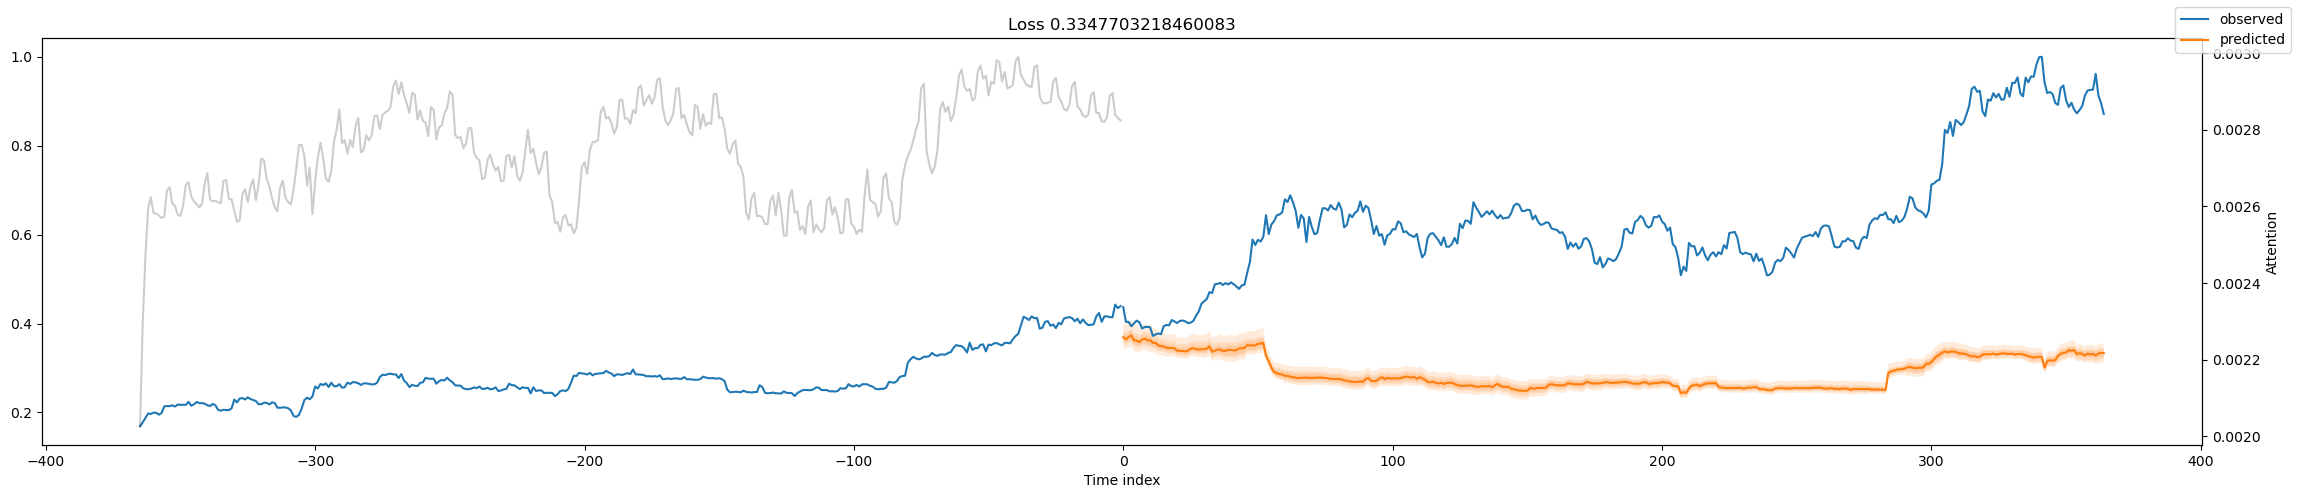

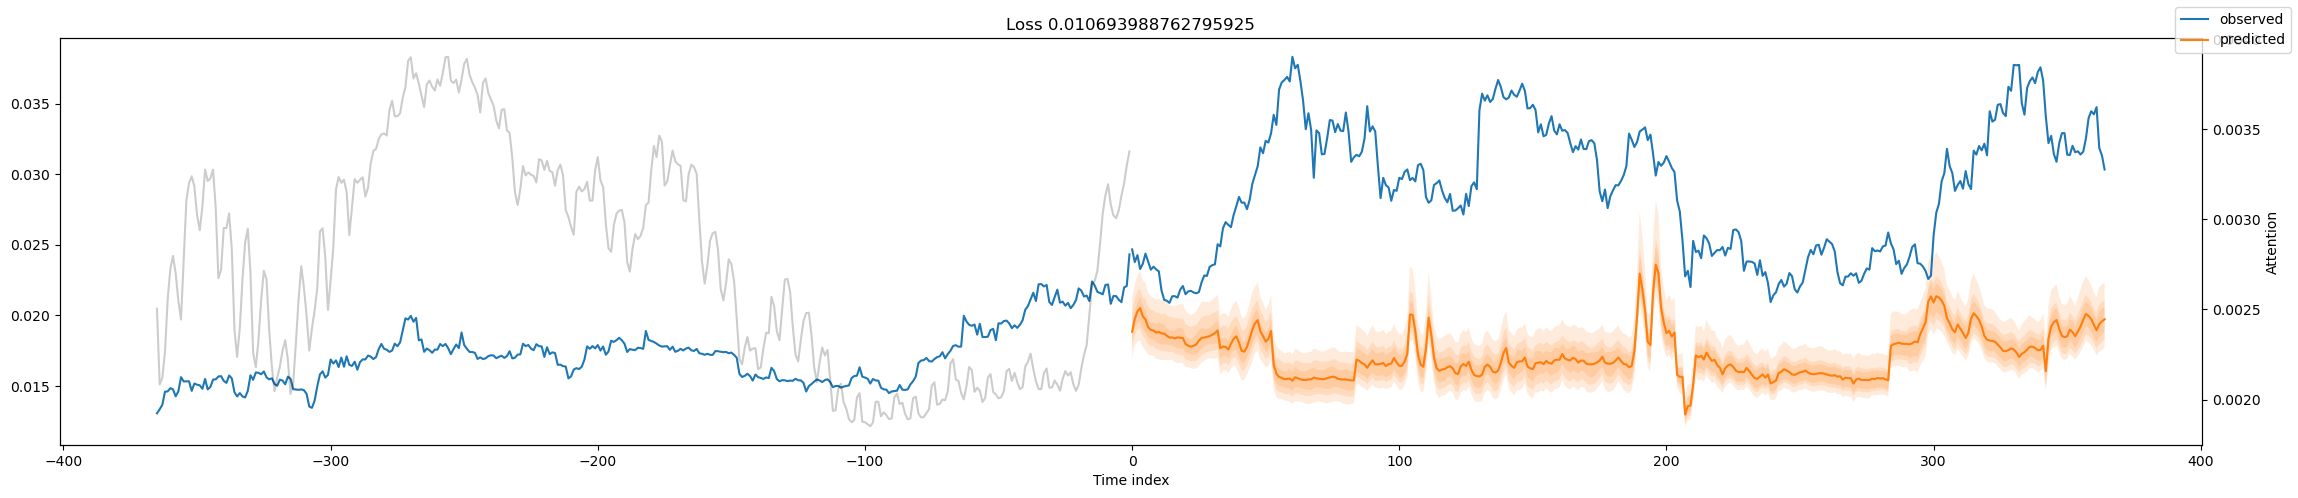

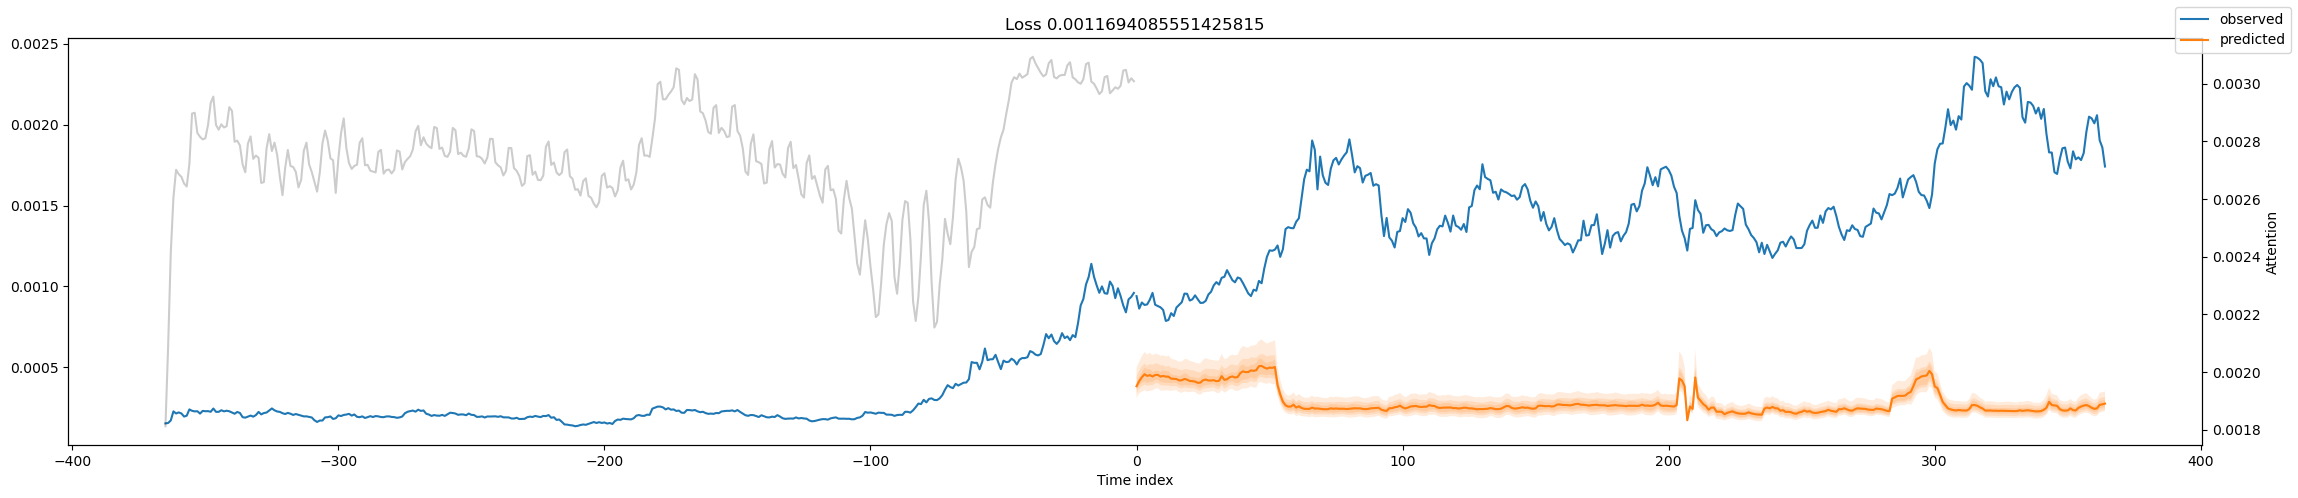

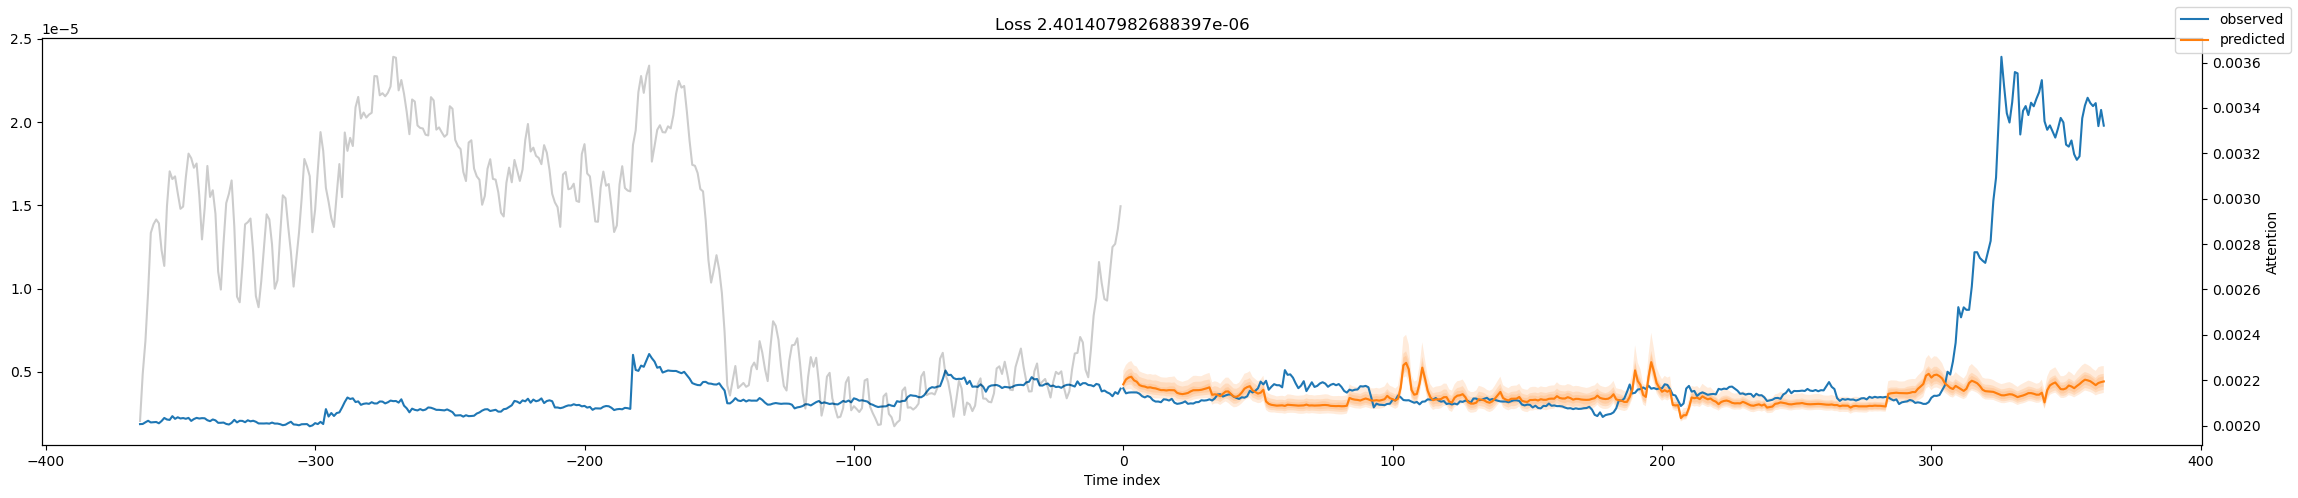

In [58]:
for idx in range(4):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)